In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from scipy.spatial.distance import pdist
from scipy.optimize import least_squares

from math import floor,ceil,exp
from collections import defaultdict
from itertools import product
from imageio import imread

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# %matplotlib inline

In [51]:
class BC:
    def __init__(self,X,xi=1e-3,finness=None):
        self.X = X
        self.lmax = max([x.max() - x.min() for x in X.T])
        self.lowers = [x.min() for x in X.T]
        self.highers = [x.max() for x in X.T]

        if finness == "random":
            np.random.shuffle(self.X)
            delmin = xi * np.array([np.array([np.linalg.norm(x-y) 
                                         for y in self.X[10:]]).min() 
                               for x in self.X[:10]]).mean()
        elif finness == "pdist":
            delmin = pdist(X).min()
        else:
            raise ValueError("Wrong argument is given for finness")   
        self.bimax = int(np.log2(self.lmax/delmin))
        
    def hist(self,delta):
        #=========== building histogram =========
        filled = defaultdict(int)
        mult = np.array([ceil(self.lmax / delta) ** i 
                               for i in range(self.X.shape[1])])
        for x in self.X:
            bin_map = np.array([ceil((coord - xmin) / delta) - 1
                                if coord == xmax else
                                floor((coord - xmin) / delta)
                                for coord,xmin,xmax in 
                                zip(x,self.lowers,self.highers)],dtype=int)
            which_box = np.dot(bin_map,mult)
            filled[which_box] += 1
        return len(filled), filled
    
    def get_points(self,n_points=40,out="CFD"):
        scales = np.logspace(1,self.bimax,num=n_points,base=2)
        scales = list(map(round,scales))
        Ds = [self.lmax / scale for scale in scales]
        N_del,S = [],[]
        for delta in Ds:
            elem, filled = self.hist(delta)
            N_del.append(elem)
            
            elem = sum([v ** 2 for _,v in filled.items()])
            S.append(elem)
        if out == "CFD":
            return np.log2(Ds),np.log2(S)
        return np.log2(scales),np.log2(N_del)

In [42]:
def msigma(x,a,b,c,d):
    return a / (1 + np.exp(b * x + c)) + d

def dmsigma(x,a,b,c,d):
    return -a * b * exp(b * x + c) / (1 + exp(b * x + c)) ** 2

def fun(x,t,y):
    return x[0] / (1 + np.exp(x[1] * t + x[2])) + x[3] - y

x0 = np.array([1,-3,0,0])

def jac_fun(x,t,y):
    return np.array(
        [1. / (1 + np.exp(x[1] * t + x[2])),
        -x[0] * np.exp(x[1] * t + x[2]) * t / (1 + np.exp(x[1] * t + x[2])) ** 2,
        -x[0] * np.exp(x[1] * t + x[2]) / (1 + np.exp(x[1] * t + x[2])) ** 2,
        np.ones(len(t))]).T

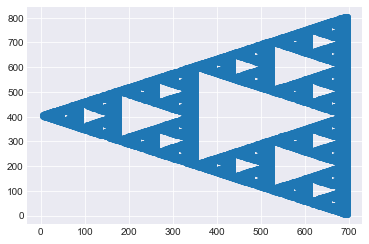

In [43]:
triangle = imread("triangle.jpg")

pixels = np.add.reduce(triangle,axis=2)
x,y = np.where(pixels==0)
data = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))

plt.scatter(x,y)

In [44]:
 def gen_data(X,noise=0, #n_outliers=0, 
             random_state=0):
    Q = X.T[0] * X.T[1] * X.T[2] ** 3  # X.T[0] = 2. / (3 * mu)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(X.shape[0])
    #outliers = rnd.randint(0, t.size, n_outliers)
    #error[outliers] *= 10

    return Q + error

In [45]:
n_samples = 50000
n_cols = 6
X = np.random.uniform(0.1,3,(n_samples,n_cols))
columns = np.array(['a',"dp",'h',"red1","red2","red3"])
df = pd.DataFrame(X,columns=columns)

df["dp+h"] = X.T[1] + X.T[2]
df["dp*h"] = np.multiply(X.T[1],X.T[2])
df["sqrt(dp)*h+exp(h)*dp**2"] = np.sqrt(X.T[1]) * X.T[2] + np.multiply(np.exp(X.T[2]),np.square(X.T[1]))

y_train = gen_data(X,noise=0.1)
df["y_train"] = y_train

columns = df.columns
n_cols = len(columns)
print("Choose column from",columns,"\nTotal is", n_cols)

sen = input("Enter only digits:")
if sen: 
    if len(sen) < n_cols: sen += "0" * (n_cols - len(sen)) #padding
    selected = np.array(list(sen),dtype=int)[:n_cols]
else: 
    selected = np.array([1,1,1] + [0]* (n_cols - 4) + [1])
data = df[columns[selected > 0]].values
print("The attributes selected are", columns[selected > 0])
df.describe()

Choose column from Index(['a', 'dp', 'h', 'red1', 'red2', 'red3', 'dp+h', 'dp*h',
       'sqrt(dp)*h+exp(h)*dp**2', 'y_train'],
      dtype='object') 
Total is 10
Enter only digits:1110001101
The attributes selected are Index(['a', 'dp', 'h', 'dp+h', 'dp*h', 'y_train'], dtype='object')


,a,dp,h,red1,red2,red3,dp+h,dp*h,sqrt(dp)*h+exp(h)*dp**2,y_train
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.552328,1.548484,1.549477,1.552231,1.557139,1.553571,3.097961,2.396580,22.020000,16.736888
std,0.837495,0.836141,0.837220,0.836886,0.838756,0.834842,1.180910,1.955536,28.231539,27.524510
min,0.100145,0.100091,0.100017,0.100024,0.100037,0.100067,0.220042,0.012027,0.050513,-0.324576
25%,0.828249,0.824821,0.826110,0.831683,0.832746,0.834455,2.246583,0.786694,3.746293,0.705060
50%,1.555304,1.549505,1.549549,1.554555,1.560352,1.554183,3.096212,1.853881,10.907733,4.902508
75%,2.275450,2.269600,2.275488,2.280282,2.286842,2.276296,3.945308,3.587736,28.250031,20.054569
max,2.999975,2.999999,2.999975,2.999871,2.999952,2.999964,5.977110,8.931434,182.212647,230.371688


In [46]:
bc = BC(data,finness="pdist")
out = "CFD"
x,y = bc.get_points(40,out=out)

In [47]:
res_lsq = least_squares(fun,x0,jac=jac_fun,args=(x, y))
res_lsq.x

array([15.513963  , -0.95403054, -0.04594055, 15.32887345])

The value of dmsigma in the focal point is 3.7001986161043527


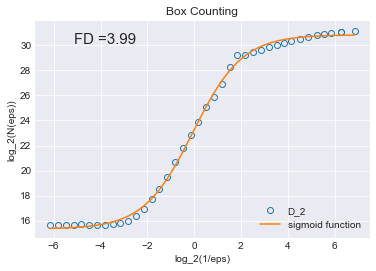

In [48]:
line1, = plt.plot(x,y,'o',mfc='none')
plt.title("Box Counting")
plt.xlabel("log_2(1/eps)")
plt.ylabel("log_2(N(eps))")
line2, = plt.plot(x,msigma(x,*res_lsq.x))

try: coefs
except NameError: 
    coefs = [0,0]
    print("coefs is not defined, so the correct value of FD will not be displayed.\
    \nExecute the next block of code and then try again.\n")
    
plt.text(min(x)+1,max(y)-1,"FD ={:.2f}".format(coefs[0]),fontsize=15)
plt.legend((line1,line2),("D_2","sigmoid function"),loc=4)
print("The value of dmsigma in the focal point is",dmsigma(-res_lsq.x[2]/res_lsq.x[1],*res_lsq.x))
plt.savefig("bc_plot.png",dpi=1000)
del coefs

In [53]:
mask = np.ones(x.shape,dtype=bool)
sen = input("Enter the boundary values separated by space:")
if sen:
    l,r = map(float,sen.split())
mask[x < l] = False
mask[x > r] = False
coefs = np.polyfit(x[mask],y[mask],deg=1)
print("Capacity dimension is",coefs[0])
print("The current spacing limits are:", l, r)

Enter the boundary values separated by space:-1 1
Capacity dimension is 3.1563145583977006
The current spacing limits are: -1.0 1.0
